# Eindimensionales Modell von zwei wechselwirkenden geladenen Teilchen gefangen in einem beliebigen Potential

In diesem Notebook verwende ich die Finite-Differenzen-Methode um das Problem von zwei geladenen Teilchen in einem eindimensionalen Potential zu lösen. Bestimmte Parameter können verändert werden. Die standardmäßigen Einstellungen repräsentieren zwei Elektronen, die per Coulomb-Potential wechselwirken.

Das eindimensionale Einteilchenpotential kann beliebig gewählt werden. Vorprogrammiert gibt es 3 verschiedene Möglichkeiten das Potential zu wählen:
* unendlich tiefer Potentialtopf
* harmonisches Potential
* Doppelmuldenpotential

Die Quelldatein sind hier verfügbar:
https://github.com/steinerstephan/FDM-Zwei-Teilchen-in-eindimensionalen-Potential

## Programm

Zuerst werden die notwendigen Bibliotheken importiert.

In [1]:
import sys
import math
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plot

Hier definieren wir die Konstanten, die für die Berechnungen verwendet werden sollen. In diesem Programm verwenden wir die Hartee-Einheiten. Die Variable max_int wird nur für das Sortieren der Ergebnisse verwendet und hat daher keine physikalische Bedeutung in diesem Program.

In [2]:
max_int = sys.maxsize
hbar = 1

Im nächsten Programmabschnitt werden die Eingangs-Parameter definiert, welche einerseits physikalische Eigenschaften des Systems verändern (Ladung und Masse) und andererseits die Genauigkeit der Simulation beeinflussen (Schrittweite und Anzahl der Punkte).

* step_size: Schrittweite
* number_of_data_points: Anzahl der Datenpunkte (die die Länge des Raumes bestimmt)
* charge: Ladung der Teilchen (-1 für Elektronen)
* mass: Masse der Teilchen (1 für Elektronen)

In [3]:
step_size = 0.08
number_of_data_points = 50 - 1
charge = -1
mass = 1

Hier reduzieren wir die Datenpunkte vom Quadrat auf das Dreieck, welches wir betrachten. (Details dazu in der Bachalorarbeit)

In [4]:
# calculate triangle points / inner points
triangle_points = 0

# add elements of row / row after row
for i in range(number_of_data_points):
    triangle_points += i
    
print('Triangle Points (Internal Points): ' + str(triangle_points))

Triangle Points (Internal Points): 1176


### Berechnung der kinetischen Energiematrix

In [5]:
# init kinetic matrix
kinetic = np.zeros((triangle_points, triangle_points))

# set diagonal elements
for i in range(triangle_points):
    kinetic[i,i] = 4

# set off diagonal elements
index = 0
for j in range(2 , number_of_data_points, 1):
    for i in range(number_of_data_points - j):
        kinetic[index,index+1] = -1
        index += 1
        kinetic[index,index-1] = -1
        kinetic[index,index+number_of_data_points - j] = -1
        kinetic[index+number_of_data_points - j,index] = -1
    index +=1
    
# add multiplier
kinetic_multiplier = np.square(hbar) / (2 * mass * np.square(step_size))
kinetic = kinetic * kinetic_multiplier

### Berechnung der Coulomb-Potential-Matrix

In [6]:
# init coulomb matrix
coulomb = np.zeros((triangle_points, triangle_points))

# calculate coulomb potential matrix
counter = 0
for j in range(number_of_data_points - 1):
    for i in range(number_of_data_points - j -1):
        coulomb[counter, counter] = np.reciprocal((i + 1) * step_size)
        counter += 1

### Definition des Einteilchenpotentials

In diesem Abschnitt wird das Einteilchenpotential für das Problem definiert und in einem Diagramm dargestellt.

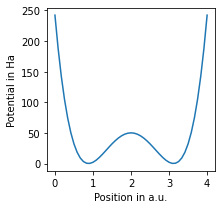

In [7]:
# calculate length of the space
length = step_size * (number_of_data_points + 1)
# get discretized positions
x_positions = np.linspace(0, length, number_of_data_points)
# init potential array
potential_in_space = np.zeros(number_of_data_points)


# Harmonic Potential
if False:
    a = 60
    for i in range(len(x_positions)):
        potential_in_space[i] = a * np.square(x_positions[i] - length / 2)

# Double Well Potential
if True:
    a = 80
    c = 0.4
    for i in range(len(x_positions)):
        potential_in_space[i] = 50 + a * (c * np.power(x_positions[i] - length / 2, 4) - np.power(x_positions[i] - length / 2, 2))

        
# change plot size
plot.figure(figsize=(3, 3))

plot.plot(x_positions, potential_in_space)
# uncomment next line to display potential well
# plot.vlines(x=[0, length], ymin=0, ymax=250)

# set font size selection
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

# set font sizes
plot.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plot.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plot.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plot.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plot.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plot.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plot.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# set axis labels
plot.xticks(range(0,5,1))
plot.xlabel('Position in a.u.')
plot.ylabel('Potential in Ha')

plot.show()

### Berechnung der Einteilchen-Potentialmatrix

In [8]:
# init potential matrix
potential = np.zeros((triangle_points, triangle_points))

# translate potential matrix to triangle form
counter = 0
for k in range(number_of_data_points - 1):
    for j in range(k + 1, number_of_data_points, 1):
        potential[counter, counter] = potential_in_space[j] + potential_in_space[k]
        counter += 1

### Bildung des Hamiltonians und Lösung des Eigenwertproblems

In [9]:
# sum up energy components for hamiltonian
hamiltonian = kinetic + coulomb + potential

# solve eigenvalue problem    
eigenvalues, eigenvectors = la.eigh(hamiltonian)
# cast eigenvalues to real numbers
eigenvalues = np.real(eigenvalues)

### Information zur Ausgabe und Darstellung extrahieren

In [12]:
display_values = []
# display_vectors will be used for the plots therefore only one triangle
display_vectors = []
# eigen_vectors will be used for pair correlation function and normalization
eigen_vectors = []

for i in range(21):
    # get index of smalles eigenvalue
    index = np.argmin(eigenvalues)
    
    # append value and vector to display arrays and eigenvector array
    # and set value
    display_values.append(eigenvalues[index])
    display_vectors.append(np.zeros(np.square(number_of_data_points + 1)))
    eigen_vectors.append(np.zeros(np.square(number_of_data_points + 1)))
    
    # arrange vectors
    display_vectors[i] = display_vectors[i].reshape((number_of_data_points + 1, number_of_data_points + 1))
    eigen_vectors[i] = eigen_vectors[i].reshape((number_of_data_points + 1, number_of_data_points + 1))
    
    # fill vectors
    counter = 0
    for k in range(number_of_data_points):
        for j in range(k + 1, number_of_data_points, 1):
            display_vectors[i][k, j] = eigenvectors[counter,index]
            eigen_vectors[i][k, j] = eigenvectors[counter,index]
            eigen_vectors[i][j, k] = eigenvectors[counter,index]
            
            counter += 1
            
    # normalize vectors        
    sum = 0        
    for k in range(number_of_data_points):
        for j in range(number_of_data_points):
            sum += eigen_vectors[i][k, j] * eigen_vectors[i][k, j] * step_size
    
    for k in range(number_of_data_points):
        for j in range(k + 1, number_of_data_points, 1):
            display_vectors[i][k, j] = display_vectors[i][k, j] / sum
            eigen_vectors[i][k, j] = eigen_vectors[i][k, j] / sum
            eigen_vectors[i][j, k] = eigen_vectors[i][j, k] / sum
    
    # set value in initial array to high number, so the next loop run will find the next bigger number
    eigenvalues[index] = max_int

### Ausgabe der Energieeigenwerte

In [13]:
# print energy values of eigen states
print('Ground State: ' + str(display_values[0]))
print('First Excited State: ' + str(display_values[1]))
print('Second Excited State: ' + str(display_values[2]))
print('Third Excited State: ' + str(display_values[3]))
#print('Fourth Excited State: ' + str(display_values[4]))
print('Fifth Excited State: ' + str(display_values[5]))
print('Tenth Excited State: ' + str(display_values[10]))
print('Fifteenth Excited State: ' + str(display_values[15]))
print('Twentieth Excited State: ' + str(display_values[20]))

Ground State: 18.534636060269467
First Excited State: 35.473737054014855
Second Excited State: 35.48890467412663
Third Excited State: 38.12121963346628
Fifth Excited State: 50.276197665985
Tenth Excited State: 61.11224257996046
Fifteenth Excited State: 67.26906540779895
Twentieth Excited State: 78.06086738012172


### Darstellung als Diagramme

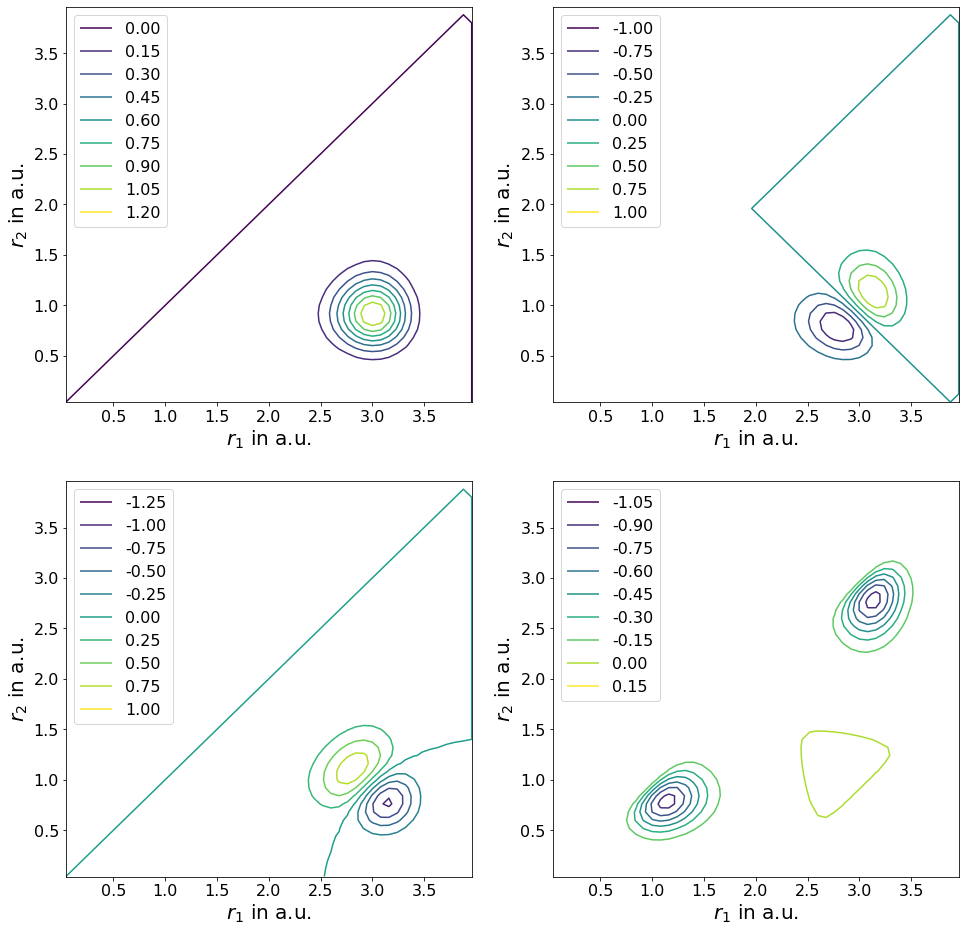

In [14]:
# init plots
fig, _ax = plot.subplots(nrows=2, ncols=2)
ax = _ax.flatten()

# set size of plot
fig.set_size_inches(16, 16)

# arrange data
x = y = np.arange(0, step_size * (number_of_data_points + 1), step_size)
X, Y = np.meshgrid(x+0.04, y+0.04)

for i in range(4):
    # set axis labels
    ax[i].set_xlabel('$r_1$ in a.u.', fontsize=20)
    ax[i].set_ylabel('$r_2$ in a.u.', fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=16)
    
    # draw plot
    CS = ax[i].contour(X, Y, display_vectors[i])

    # set legend
    h = CS.collections
    l = [f'{a:.2f}' for a in CS.levels]
    ax[i].legend(h, l, loc='upper left', fontsize=16)
     
plot.show()

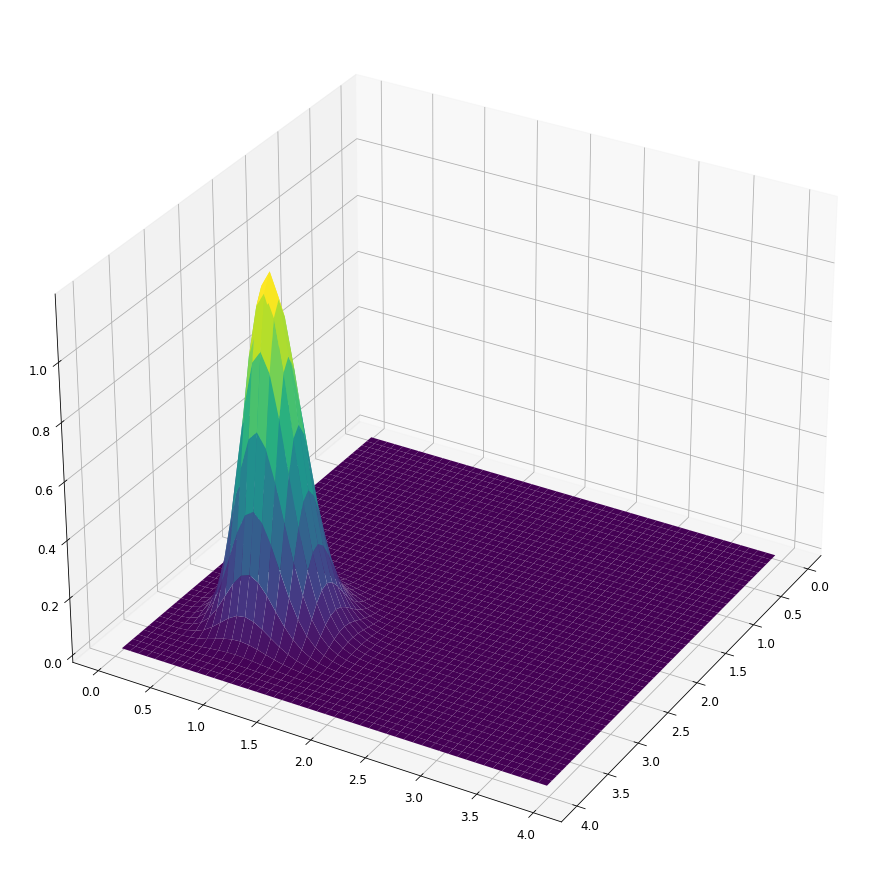

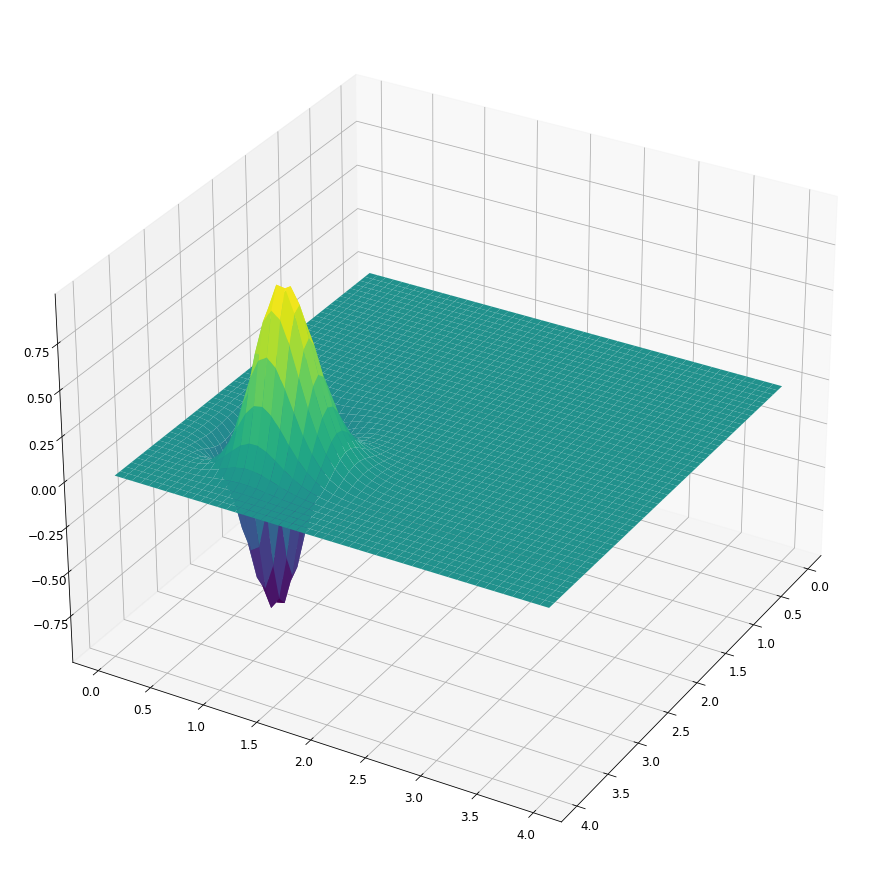

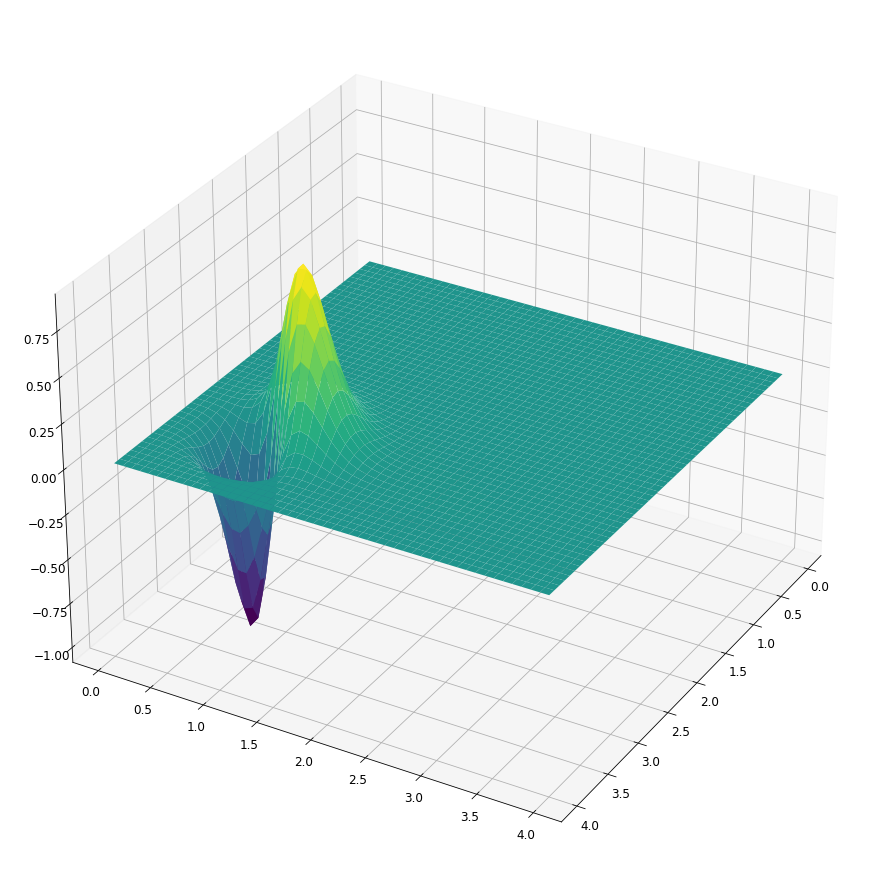

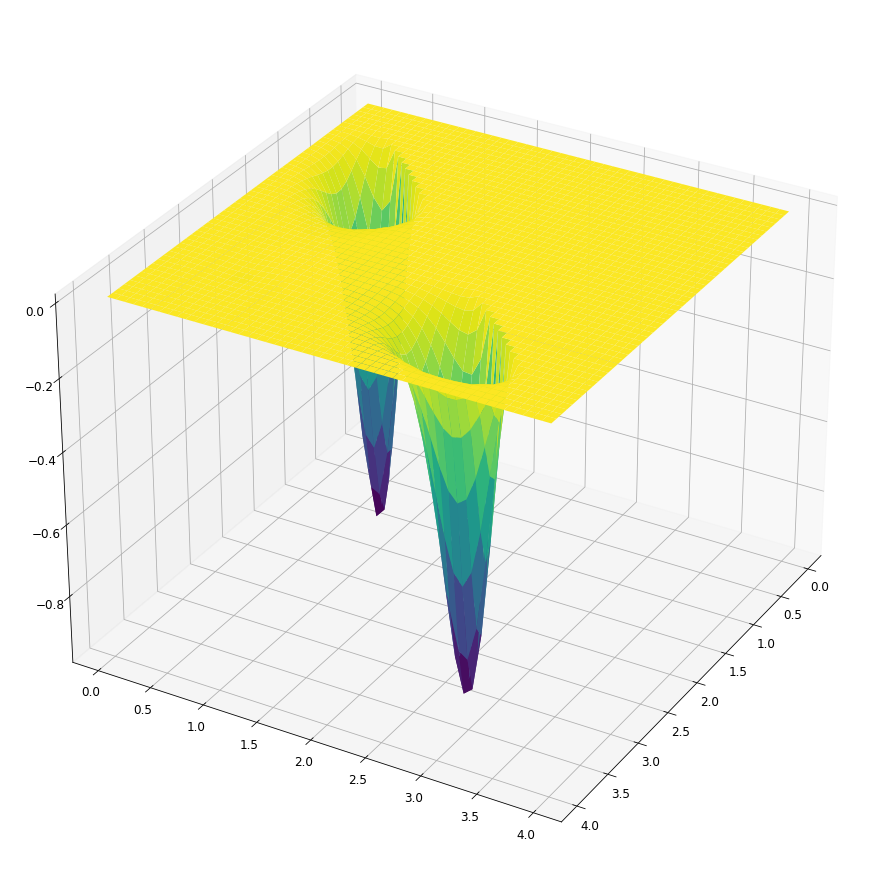

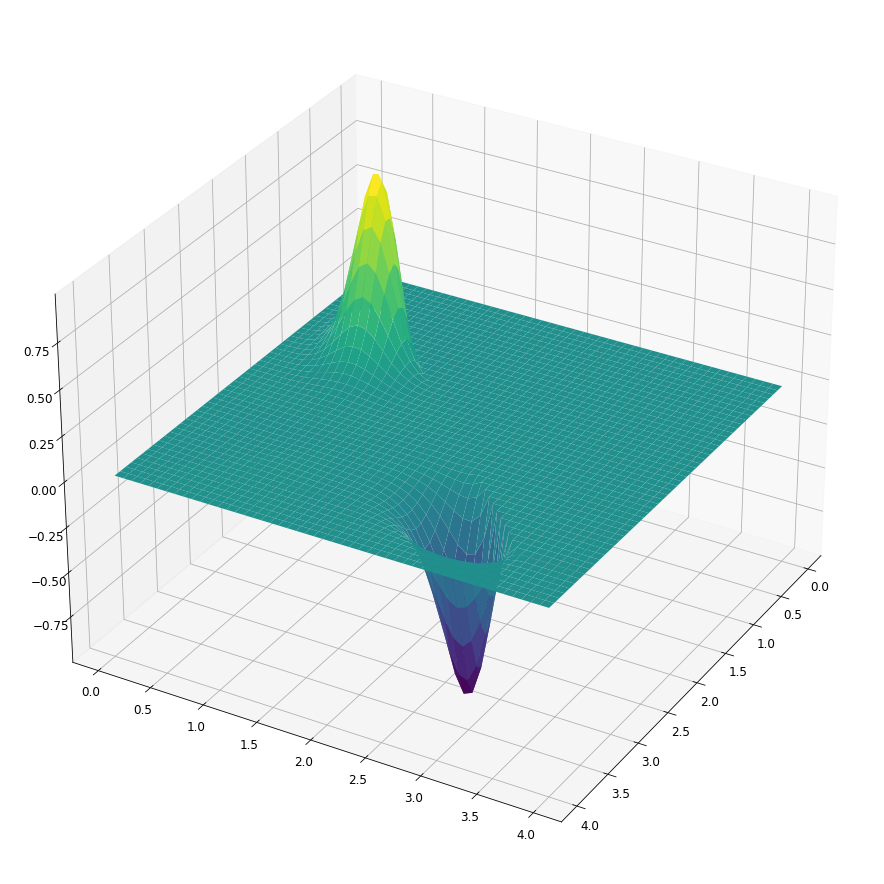

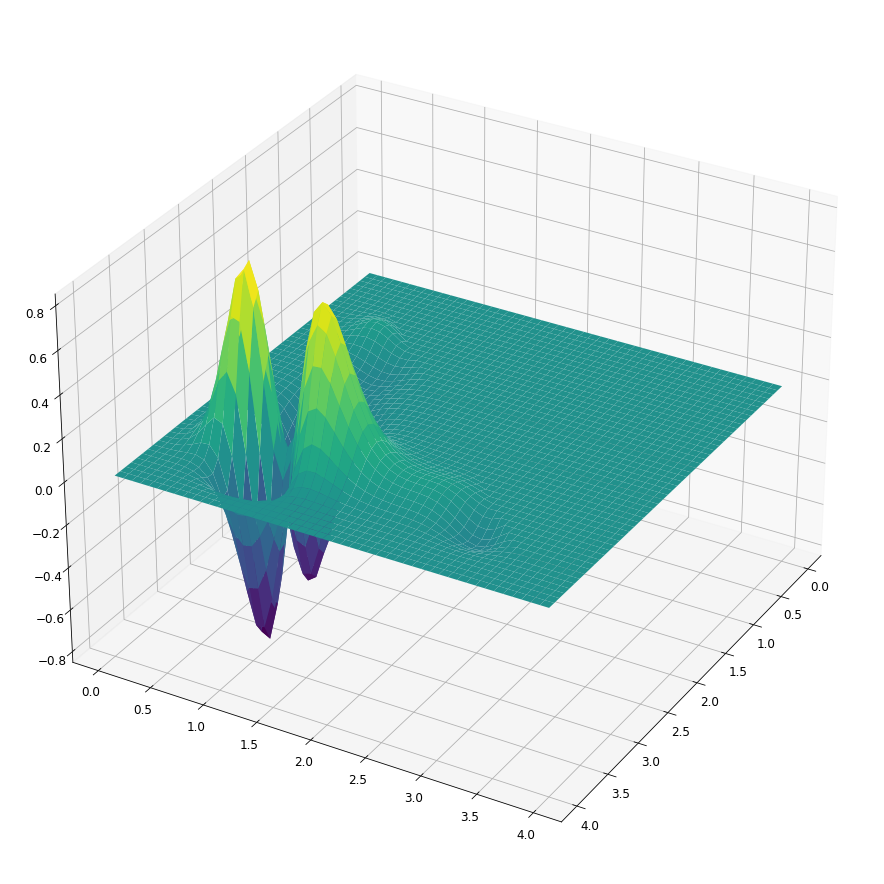

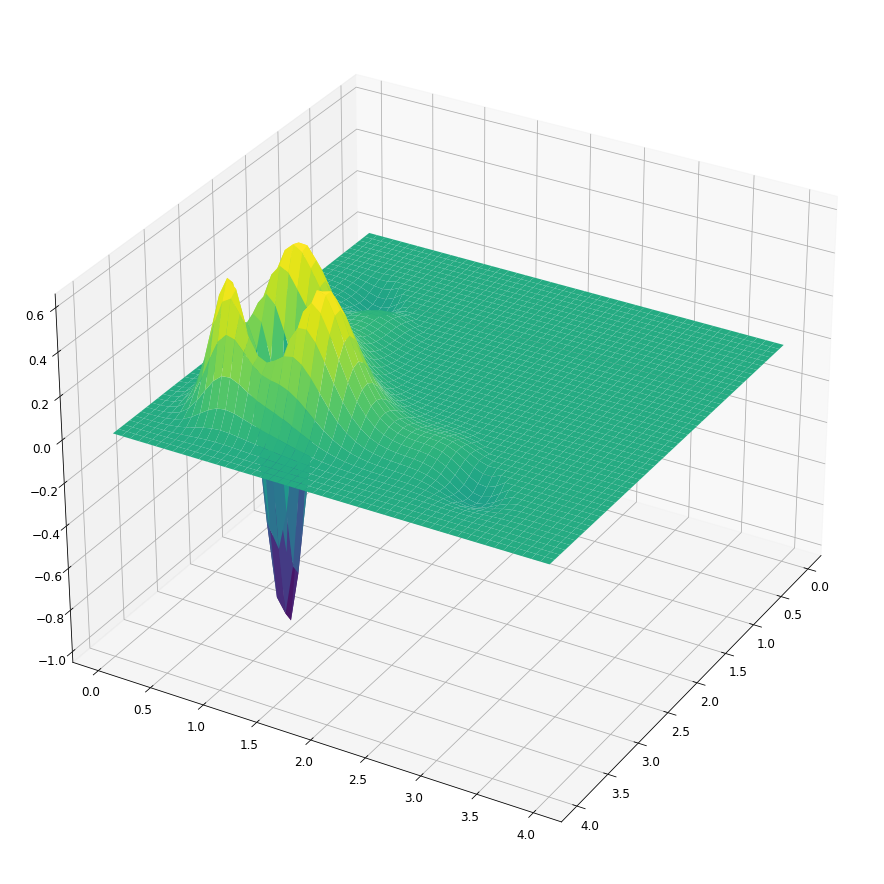

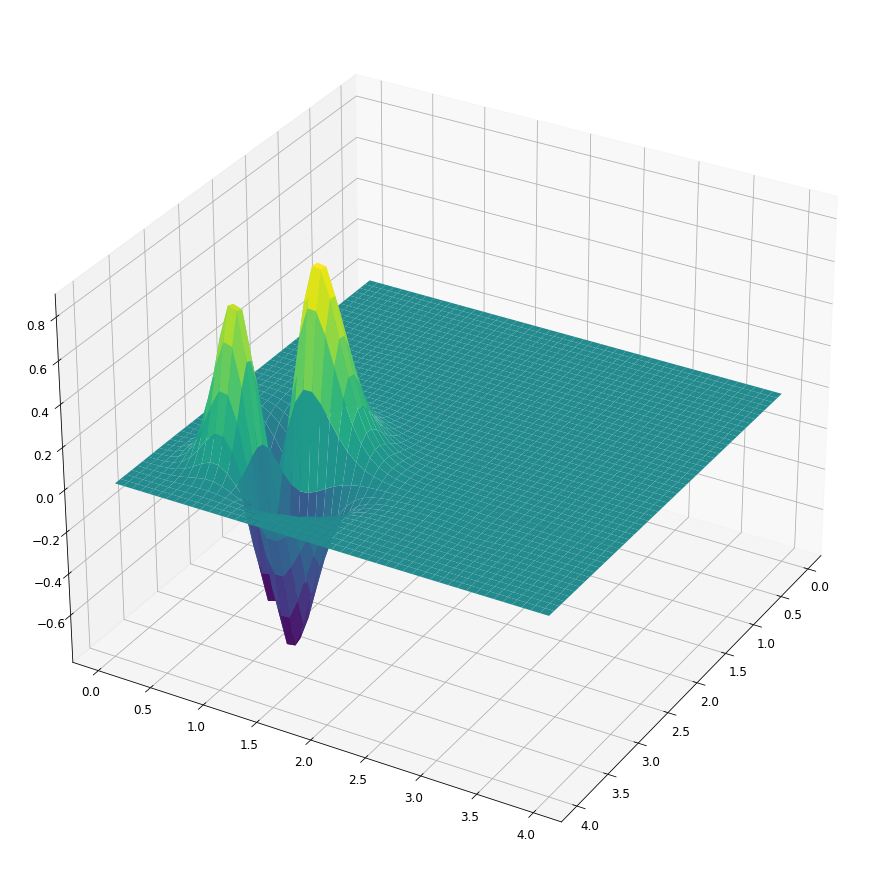

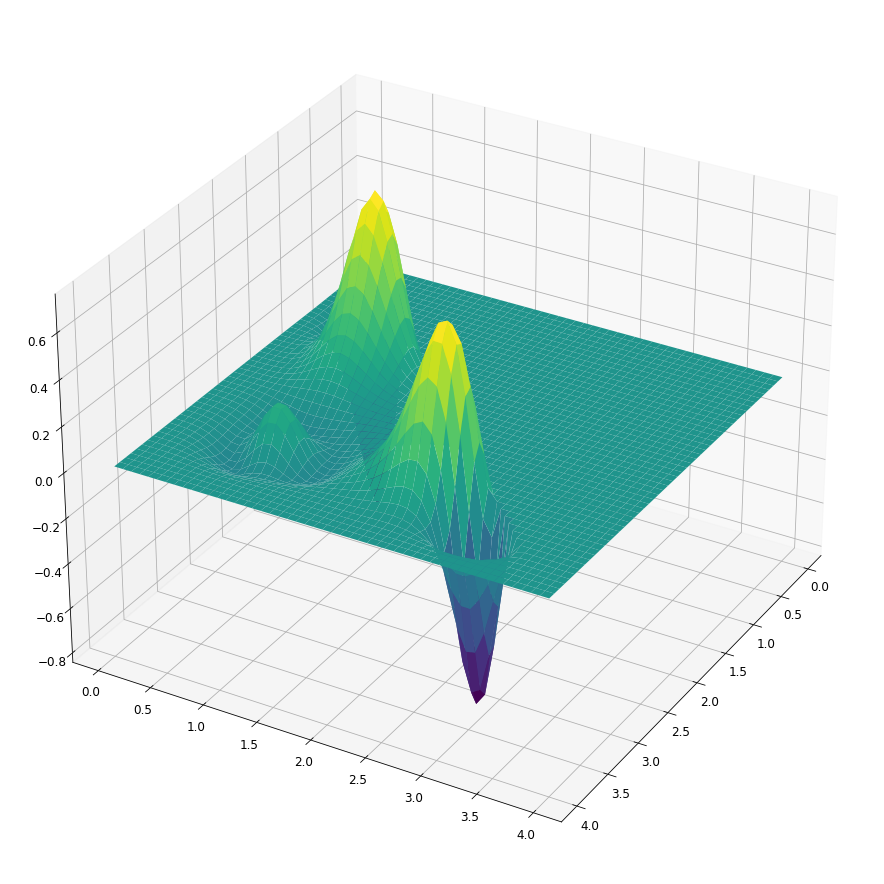

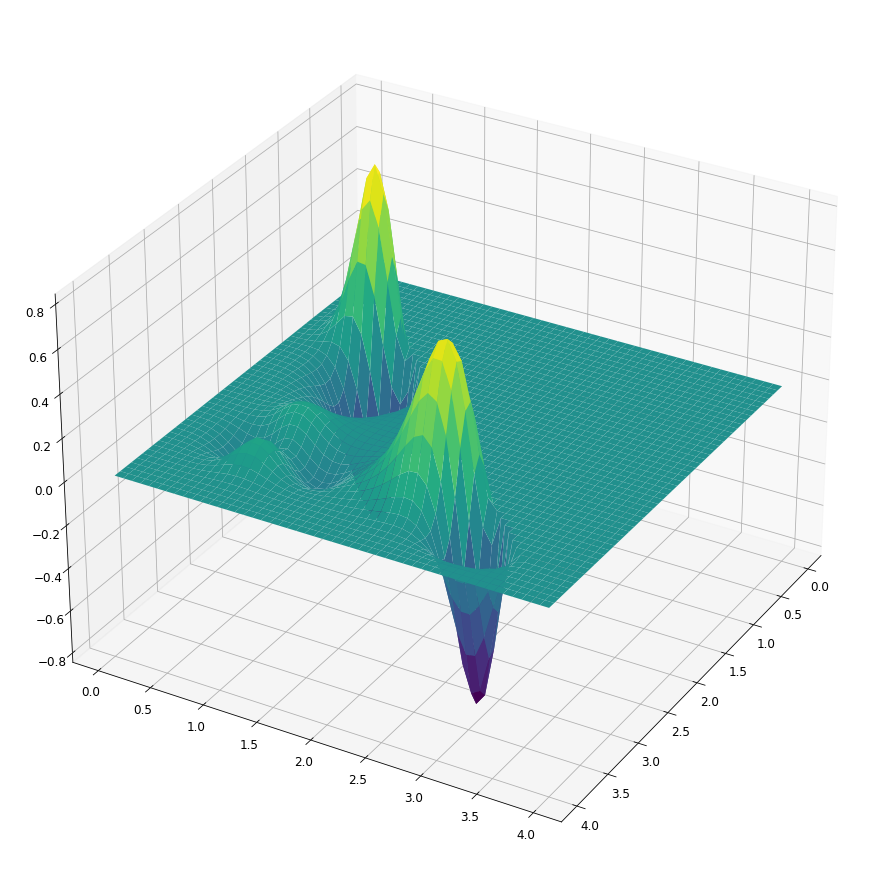

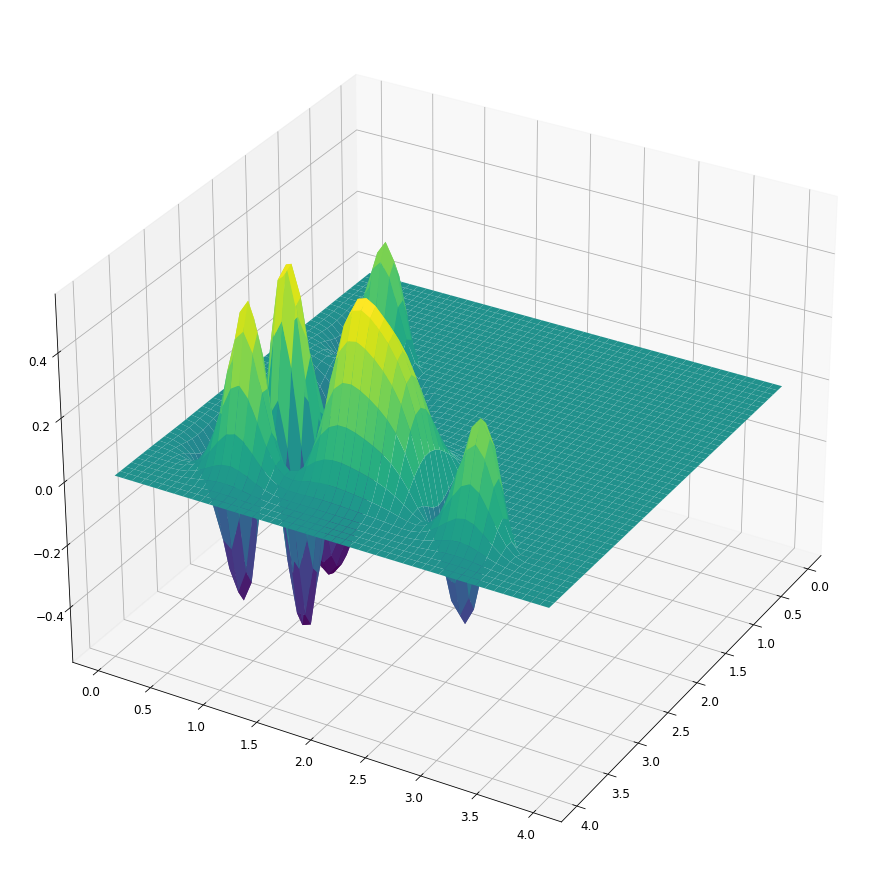

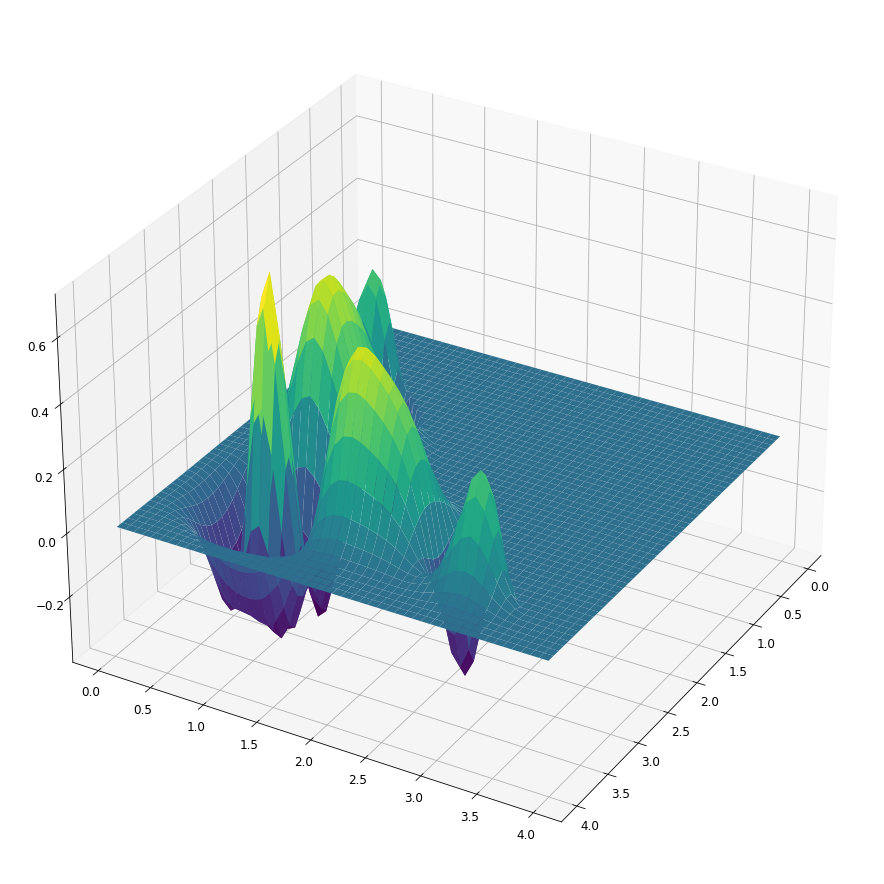

In [15]:
fig_2 = []
ax_2 = []

for i in range(12):
    # init plots
    fig_2.append(plot.figure())
    ax_2.append(plot.axes(projection='3d'))

    # set size of plot
    fig_2[i].set_size_inches(16, 16)

    # draw plot
    ax_2[i].plot_surface(X, Y, display_vectors[i], rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax_2[i].view_init(30, 30)

### Berechnung und Darstellung der Paarkorrelationsfunktion

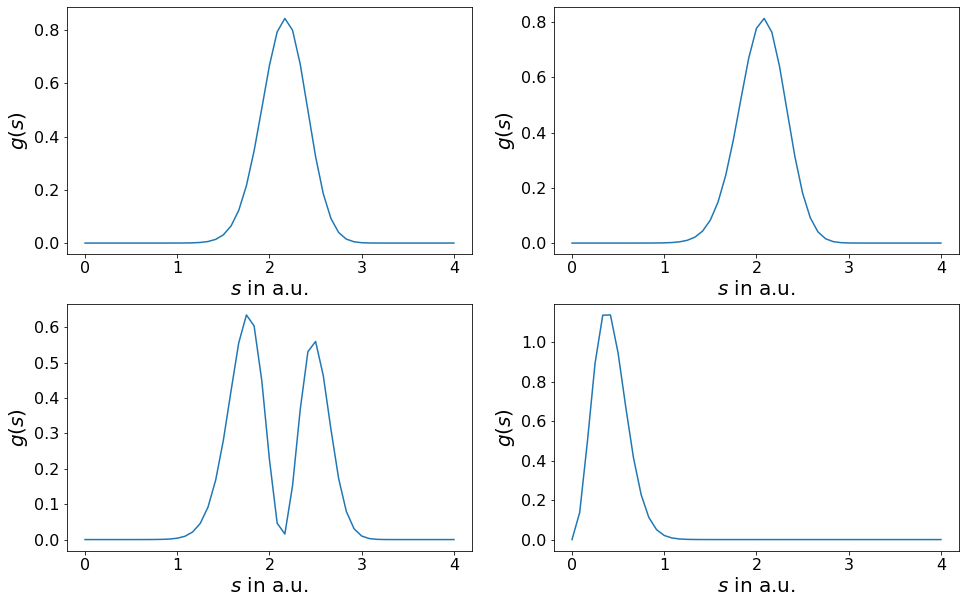

In [16]:
correlation_functions = []

# calculate pair correlation function
for k in range(6):
    for i in range(number_of_data_points):
        correlation_functions.append(np.zeros(number_of_data_points))

        for j in range(number_of_data_points):
            if (j + i) < number_of_data_points:
                correlation_functions[k][i] += eigen_vectors[k][j, j + i] * eigen_vectors[k][j, j + i] * step_size
            if (j - i) >= 0:
                correlation_functions[k][i] += eigen_vectors[k][j, j - i] * eigen_vectors[k][j, j - i] * step_size
        
# generate data for x axis / plot area
x = np.linspace(0, 4, number_of_data_points)
    
# init plots
fig, _ax = plot.subplots(nrows=2, ncols=2)
ax = _ax.flatten()

# set size of plot
fig.set_size_inches(16, 10)

for i in range(4):
    # draw plots
    ax[i].plot(x, correlation_functions[i])
    
    # set axis labels
    ax[i].set_xlabel('$s$ in a.u.', fontsize=20)
    ax[i].set_ylabel('$g(s)$', fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=16)

plot.show()